In [1]:
##############################################################################
#	Project		:	Age Estimation
#	Pipeline	:	E2ePipeline3
#	Date		:	1.11.2023
# 	Description	: 	Main run file
##############################################################################

import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import pickle
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from datetime import datetime
from Common.Datasets.Morph2.data_parser import DataParser
from Common.Datasets.Morph2.dataset_utils import gen_dist_and_isol_test_sets_no_im2age_map
from Common.Losses.MeanVarianceLoss import MeanVarianceLoss
from Common.Losses.YprojOrdinalMeanVarianceLoss import OrdinalMeanVarianceLoss
from tqdm import tqdm

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler
from Common.Analysis.GeneralMethods import get_statistics, get_statistics_range
from Common.Datasets.Morph2.dataset_utils import *
from Common.Datasets.CACD.CacdDataParser import CacdDataParser



import ep3_config as cfg
from ep3_dataset import QueryAndMultiAgeRefsDataset
from ep3_model import DiffBasedAgeDetectionModel, PerNoisyRangeAgeModel
from ep3_train import train



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

if cfg.USE_GPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

# Load data
# data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
# data_parser.initialize_data()
print(f"Dataset: {cfg.DATASET_SELECT}")
print("Reading dataset...")

# Load data
if cfg.DATASET_SELECT == "Morph2":
	data_parser = DataParser(cfg.MORPH2_DATASET_PATH, small_data=cfg.SMALL_DATA)
	data_parser.initialize_data()
	x_train, y_train, x_test, y_test, chosen_idxs_trn, chosen_idxs_tst = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test, data_parser.chosen_idxs_trn, data_parser.chosen_idxs_tst
elif cfg.DATASET_SELECT == "CACD":
	data_parser = CacdDataParser(cfg.CACD_DATASET_PATH)
	data_parser.initialize_data()
	x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test


if cfg.RANDOM_SPLIT:
	print("Random split mode is currently not supported. Aborting")
	exit()

	all_images = np.concatenate((x_train, x_test), axis=0)
	all_labels = np.concatenate((y_train, y_test), axis=0)

	x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)

#####################################################
#           Metadata Loading
#####################################################

# Emebeddings loading
face2emb_arr_trn_r = np.load(f'{cfg.DATASET_SELECT}_face2emb_arr_trn_recog.npy', allow_pickle=True)
face2emb_arr_vld_r = np.load(f'{cfg.DATASET_SELECT}_face2emb_arr_vld_recog.npy', allow_pickle=True)

if cfg.SMALL_DATA:
	if cfg.APPLY_TRAIN_SET_SPLIT_FOR_DIST_AND_ISOL or cfg.APPLY_TEST_SET_SPLIT_FOR_DIST_AND_ISOL:
		print("Unsupported modes from small data. Please cancel these modes and rerun. Aborting")
		exit()

	if cfg.DATASET_SELECT == "Morph2":
		face2emb_arr_trn_r = face2emb_arr_trn_r[chosen_idxs_trn]
		face2emb_arr_vld_r = face2emb_arr_vld_r[chosen_idxs_tst]
    
# Base model inference results loading
with open(cfg.INPUT_ESTIMATION_FILE_NAME_TEST, 'r') as im2age_map_test_f:
	im2age_map_test = json.load(im2age_map_test_f)

with open(cfg.INPUT_ESTIMATION_FILE_NAME_TRAIN, 'r') as im2age_map_train_and_dist_f:
	im2age_map_train_and_dist = json.load(im2age_map_train_and_dist_f)
                  

"""
Creatig now these for next stages:

train actual
test actual 
dist
embeddings train actual
embeddings test actual
map test
base_model_err_dist_on_non_trained_set
"""

if cfg.APPLY_TRAIN_SET_SPLIT_FOR_DIST_AND_ISOL:
	print("applying dist and isol train sets split")
	# load dist and isol test indexes
	with open(f'{cfg.INDEXES_SAVE_DIR}/{cfg.DATASET_SELECT}_dist_indexes.pkl', 'rb') as f_dist_indexes:
		dist_indexes = pickle.load(f_dist_indexes)
	with open(f'{cfg.INDEXES_SAVE_DIR}/{cfg.DATASET_SELECT}_isolated_train_indexes.pkl', 'rb') as f_isolated_train_indexes:
		isolated_train_indexes = pickle.load(f_isolated_train_indexes)


	print(f"Original train set size: {len(data_parser.y_train)}")

	x_train_dist, y_train_dist, im2age_map_train_dist, x_train_isol, y_train_isol, im2age_map_train_isol = gen_dist_and_isol_test_sets(x_src_dataset=data_parser.x_train, 
																										y_src_dataset=data_parser.y_train, 
																										im2age_map_src_dataset_orig=im2age_map_train_and_dist, 
																										dist_indexes=dist_indexes, 
																										isolated_src_dataset_indexed=isolated_train_indexes)

	print(f"Actual train set size: {len(y_train_isol)}")

	# Outcome to next stages
	face2emb_arr_trn_r_actual = face2emb_arr_trn_r[isolated_train_indexes]
	face2emb_arr_vld_r_actual = face2emb_arr_vld_r
	
	base_model_err_dist_on_non_trained_set = get_statistics(dataset_metadata=y_train_dist,
										dataset_indexes=[i for i in range(len(y_train_dist))], 
										im2age_map_batst=im2age_map_train_dist)
	
	print(f"""MAE (dist): {np.mean(np.abs(base_model_err_dist_on_non_trained_set["data"]))}""")
	
	train_set_stats = get_statistics(dataset_metadata=y_train_isol,
										dataset_indexes=[i for i in range(len(y_train_isol))], 
										im2age_map_batst=im2age_map_train_isol)
	
	print(f"""MAE (train): {np.mean(np.abs(train_set_stats["data"]))}""")
	
	test_set_stats = get_statistics(dataset_metadata=y_test,
										dataset_indexes=[i for i in range(len(y_test))], 
										im2age_map_batst=im2age_map_test)
	
	print(f"""MAE (test): {np.mean(np.abs(test_set_stats["data"]))}""")

cuda:0
Dataset: CACD
Reading dataset...
applying dist and isol train sets split
Original train set size: 130312
Actual train set size: 127024
MAE (dist): 5.79127285312272
MAE (train): 4.480957260899436
MAE (test): 5.30405695203665


In [2]:
#
for_isolated_train_err_distribution_gen_data = train_set_stats["kde"].resample(size=100000)
for_dist_err_distribution_gen_data = base_model_err_dist_on_non_trained_set["kde"].resample(size=100000)
for_test_err_distribution_gen_data = test_set_stats["kde"].resample(size=100000)



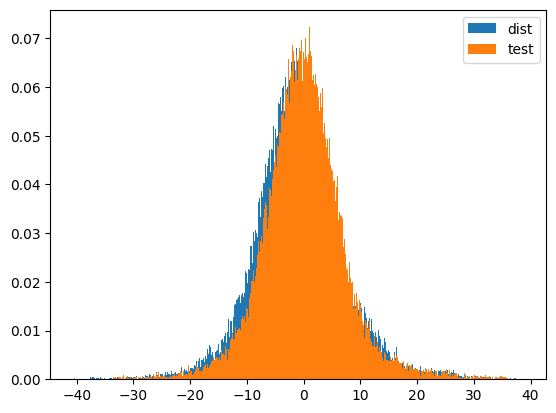

In [10]:
import matplotlib.pyplot as plt
#plt.hist(for_isolated_train_err_distribution_gen_data[0], bins=100, label="train", density=True)
plt.hist(for_dist_err_distribution_gen_data[0], bins=1000, label="dist", density=True)
plt.hist(for_test_err_distribution_gen_data[0], bins=1000, label="test", density=True)
plt.legend()


In [17]:
np.mean(np.abs(for_test_err_distribution_gen_data[0]))

2.7002385344574145

In [18]:
np.mean(np.abs(for_dist_err_distribution_gen_data[0]))

2.976671400483779

In [48]:
np.mean(np.abs(for_isolated_test_err_distribution['data']))

2.589721939012102